<h1> Imports </h1>

In [3]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib
import os.path
from messaging.telegrambot import Bot
import telegram
import sys,os
sources_path = './../Sources'
if sources_path not in sys.path:
    sys.path.append(sources_path)
from Recommender.evaluation import MSE, RMSE, MAE
from Recommender.preprocessing import *
from Recommender.environment import saveVariable, saveFigure, loadVariable

#sys.path.append('../Sources') # Adding my own libs source
#from StackedAutoEncoderRS.SAERS import SAE

<h1> Defining Variables </h1>

In [4]:
%matplotlib inline
results_path = './Results/'
verbose = True

<h1>Loading Dataset</h1>

- You can study different sparsity scenarios with different datasets. 

<h2> Movie Lens Dataset </h2>
There are 4 movieLens datasets available: the 100k, 1M, 10M and 20M datasets. To choose one of them, just simply uncomment the 'dataset_path' variable according to the respective folder 

In [5]:
%%time
#Loading dataset

dataset = '100k/' #100k dataset path
#dataset = '10M/' #10M dataset path
#dataset = '20M/' #20M dataset path

dataset_path = '../../Datasets/movieLens/' + dataset; # Full dataset path

filenames = {'movie': 'movie.csv', 'rating': 'rating.csv'}

df_ratings = pd.read_csv(dataset_path+filenames['rating'])

CPU times: user 26.9 ms, sys: 9.24 ms, total: 36.1 ms
Wall time: 116 ms


In [6]:
print df_ratings.info();
print df_ratings.tail();


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
userId       100000 non-null int64
itemId       100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB
None
       userId  itemId  rating  timestamp
99995     880     476       3  880175444
99996     716     204       5  879795543
99997     276    1090       1  874795795
99998      13     225       2  882399156
99999      12     203       3  879959583


<h1>Creating Users and Items IDs array</h1>
We create two arrays containing:
- Distinct UserID
- Distinct ItemID


In [7]:
%%time

#Counting Number of Unique Users and Items
usersIds, itemsIds = InitializeIds(df_ratings = df_ratings);            
            
print "Users Ids array:\t",usersIds.shape;
print "Movies Ids array:\t", itemsIds.shape;

Users Ids array:	(943,)
Movies Ids array:	(1682,)
CPU times: user 5.59 s, sys: 17.6 ms, total: 5.61 s
Wall time: 21.2 s


<h1>Creating Utility Matrix R</h1>
<p>Our Utility Matrix will have <b>users as lines</b> and <b>items as columns</b>. 

In [8]:
%%time

R, usersIds, itemsIds = LoadUtilityMatrix(df_ratings, verbose = verbose)

if (verbose):
    print ("Utility Matrix shape: {0}".format(R.shape))

    KILO = 1000.0
    MEGA = 1000*KILO;
    GIGA = 1000*MEGA
    print ("Utility Matrix Memory Usage: ".format(sys.getsizeof(R)/(GIGA)))

#Saving variable
filename = 'originalUtilityMatrix'

saveVariable(results_path, dataset, filename, R, verbose = verbose)

[*] Initializing Users and Items Ids arrays
[*] Filling Utility Matrix
[+] Utility Matrix loaded with 943 users and 1682 items.
Utility Matrix shape: (943, 1682)
Utility Matrix Memory Usage: 
[*] Saving variable to ./Results/Variables/100k/originalUtilityMatrix file
[*] Removing existing file


NameError: global name 'joblib' is not defined

In [15]:
def createUtilityMatrixPandasDataset(utility_matrix, usersIds, itemsIds):
    new_dataframe = pd.DataFrame()    
    
    stringUsersIds = [];
    stringItemsIds = [];
    stringEvaluations = [];
    
    for userCount in xrange(len(utility_matrix)):
        for itemCount in xrange(len(utility_matrix[userCount])):
            if utility_matrix[userCount][itemCount] != 0:
                stringUsersIds.append(usersIds[userCount])
                stringItemsIds.append(itemsIds[itemCount])
                stringEvaluations.append(str(int(utility_matrix[userCount][itemCount])))
    
    new_dataframe['userId'] = stringUsersIds    
    new_dataframe['itemId'] = stringItemsIds
    new_dataframe['rating'] = stringEvaluations
    return new_dataframe


In [18]:
createUtilityMatrixPandasDataset(utility_matrix = R, usersIds = usersIds, itemsIds = itemsIds).shape

# COMO INCLUIR TIMESTAMP NOS CORTES



(100000, 3)

In [11]:
#########################################################################
# RUN THIS CELL IN CASE YOU HAVE 
# MEMORY PROBLEMS INITIALIZING UTILITY MATRIX.
# This cell can give you an estimate of how big your matrix can be given 
# an specific server memory
##########################################################################
# time_zero = time.time();

#print "#Users: ", usersIds.shape[0];
#print "#Movies: ", moviesIds.shape[0];
#R = np.zeros((usersIds.shape[0], moviesIds.shape[0]));

#R = np.zeros((usersIds.shape[0], moviesIds.shape[0]))
#R = np.zeros((138493, 26744))

# for count in xrange(moviesIds.shape[0]):
#     try:
#         R = np.zeros((usersIds.shape[0],count));
#     except MemoryError: 
#         print "Error in ", count, "iteration";
#         break;

# print "Elapsed time: ", time.time()-time_zero; 
# print "Matrix R shape: ",R.shape;


<h1>Visualizing the Original Utility Matrix Sparsity</h1>
<p>To get a glimpse of how sparse our utility matrix is, we use the <b>plt.spy()</b> function.

In [24]:
# Auxiliary Functions 

def calculateOverallSparsityMeasure(utilityMatrix):
    """Calculates the Overall Sparsity (OS) Measure based on:
        OS = 1 - #evaluations/(#user * #items)"""
    numberOfEvaluations = 0;
    
    for user in utilityMatrix:
        numberOfEvaluations += np.count_nonzero(user);      
        
    try:
        if (utilityMatrix.shape[0] != 0 and utilityMatrix.shape[1] != 0):
            return 1 - float(numberOfEvaluations)/float(utilityMatrix.shape[0]*utilityMatrix.shape[1]);
        
        elif (utilityMatrix.shape[0] == 0 and utilityMatrix.shape[1] != 0):
            return 1 - float(numberOfEvaluations)/float(utilityMatrix.shape[1])
        
        elif (utilityMatrix.shape[0] != 0 and utilityMatrix.shape[1] == 0):
            return 1 - float(numberOfEvaluations)/float(utilityMatrix.shape[0])
        
        else:
            print ("Matrix shape is null in at least one dimension: {}".format(utilityMatrix.shape))
            return 0
    except:
        print ("Error when calculating overall sparsity.")
        pass

In [64]:
def plotUtilityMatrix(utility_matrix, title = 'Utility Matrix', figsize = (10,10), verbose = False):      
    
    OS = calculateOverallSparsityMeasure(utility_matrix);

    fig, ax = plt.subplots(figsize = figsize)

    ax.spy(utility_matrix, aspect='auto')
    
    plt.xlabel("Number of Items", fontsize = 22)
    plt.ylabel("Number of Users", fontsize = 22)
    plt.yticks(np.arange(0, utility_matrix.shape[0], 100))
    plt.margins(tight = True)
    plt.title('OS: {:0.3f}'.format(OS), fontsize = 22)
    plt.grid(color = 'blue', linestyle = '-')    
    plt.tick_params(axis='both', which='major', bottom = True, top = False, labelsize=20, labelbottom = True, labeltop = False)

    return plt

In [19]:
def saveFigure(results_path, dataset, filename, plot, verbose = False):
    fullpath = results_path + 'Figures/' + dataset + filename
    
    if (verbose):
        print "[*] Saving plot to {} folder",format(fullpath)
        
    plt.savefig(fullpath)
    
    if (verbose):
        print "[+] Results saved."

[*] Saving plot to {} folder ./Results/Figures/100k/unsortedUtilityMatrix.png
[+] Results saved.
CPU times: user 289 ms, sys: 47.8 ms, total: 337 ms
Wall time: 1.21 s


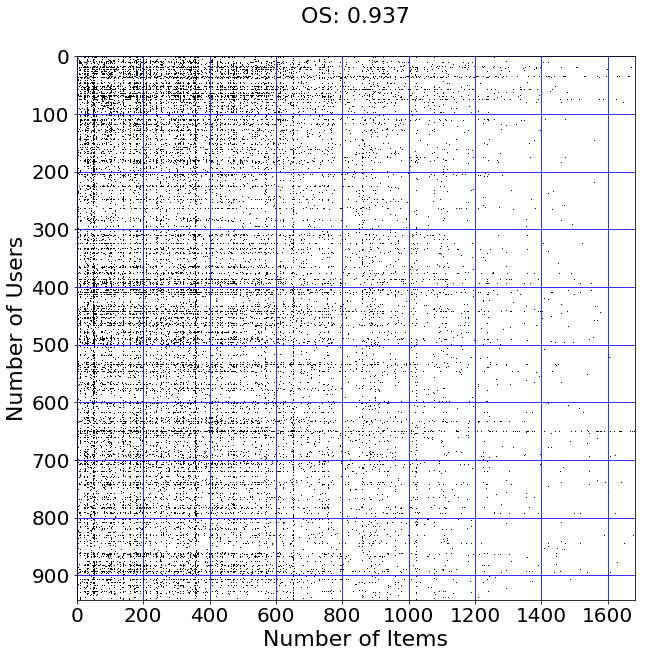

In [38]:
%%time

# Visualizing Matrix Sparsity
plot = plotUtilityMatrix(utility_matrix = R, title = 'Utility Matrix', figsize = (10,10), verbose = verbose)
saveFigure(plot = plot, results_path = results_path, dataset = dataset, filename = 'unsortedUtilityMatrix.png', verbose = True)


<h1>Sorting Utility Matrix</h1>
<p>In order to study how sparsity can influence our algorithm, we need to create an utility matrix in a way that it is more dense near low indexes elements (top left corner of matrix) and less dense new high indexes elements (bottom right corner). This will give us the ability to chop the matrix on a given sparsity measure.

In [69]:
#Auxiliary Functions

def InitializeUsersSparsity(utility_matrix):    
    usersSparsity = np.zeros(utility_matrix.shape[0]);
    usersSortedFlag = False; # If users are sorted by USS, flag turns True
    
    return usersSparsity, usersSortedFlag
    
def InitializeItemsSparsity(utility_matrix):    
    itemsSparsity = np.zeros(utility_matrix.shape[1]);
    itemsSortedFlag = False;
    
    return itemsSparsity, itemsSortedFlag

In [77]:
# Auxiliary Functions
def calculateItemsSpecificSparsityMeasure(utility_matrix, verbose = False):
    """Calculates an array of Items Specific Sparsity (ISS) measure based on:
        ISS = 1 - #i / max (#i), where #i is the number of users who rated
        item u"""
    
    issArray, itemsSortedFlag = InitializeItemsSparsity(utility_matrix)

    utility_matrix = np.transpose(utility_matrix) # Do the same as USS calculations, but transposed
    
    #issArray = calculateUsersSpecificSparsityMeasure(np.transpose(utility_matrix));
    
    issArray = np.zeros(utility_matrix.shape[0]) # Size argument
    
    count = 0
    for item in utility_matrix:
        issArray[count] = np.count_nonzero(item);
        count += 1;
        
    maxNumberOfEvaluations = np.amax(issArray)
    
    issArray = 1 - issArray/float(maxNumberOfEvaluations)
    
    itemsSortedFlag = True
            
    return issArray, itemsSortedFlag


def calculateUsersSpecificSparsityMeasure(utility_matrix, verbose = False):
    """Calculates an array of User Specific Sparsity (USS) measure based on:
        USS = 1 - #u / max (#u), where #u is the number of items rated
        by user u"""
        
    ussArray, usersSortedFlag = InitializeUsersSparsity(utility_matrix)
    
    ussArray = np.zeros(utility_matrix.shape[0]) # Size argument
    
    count = 0
    for user in utility_matrix:
        ussArray[count] = np.count_nonzero(user);
        count += 1;
        
    maxNumberOfEvaluations = np.amax(ussArray)
    
    ussArray = 1 - ussArray/float(maxNumberOfEvaluations)
    
    usersSortedFlag = True
    
    #count = 0
    
    #for user in ussArray:
    #    ussArray[count] = 1-float(ussArray[count])/maxNumberOfEvaluations;
    #    count += 1;
            
    return ussArray, usersSortedFlag


def sortItemsBySparsity(utility_matrix, itemsIds, itemsSparsity = None, itemsSortedFlag = None, verbose = False):     
    """ Sort Utility Matrix by Items Sparsity
        Returns sorted matrix and itemsSparsity array"""    
    if itemsSortedFlag == True and itemsSparsity is not None:
        if (verbose):
            print ("[*] Skipping calculation of ISS array")            
    else:
        if (verbose):
            print ("[*] Calculating ISS for every item")
            
        itemsSparsity, itemsSortedFlag = calculateItemsSpecificSparsityMeasure(utility_matrix)
        
    if (verbose):
        print ("[*] Sorting Items by ISS")
        
    itemsSortedIndex = np.argsort(itemsSparsity)
        
    itemsIds = itemsIds[itemsSortedIndex]
    
    utility_matrix = (utility_matrix.T[itemsSortedIndex]).T    
    
    return utility_matrix, itemsIds

def sortUsersBySparsity(utility_matrix, usersIds, usersSparsity = None, usersSortedFlag = None, verbose = False):     
    """ Sort Utility Matrix by Users Sparsity
        Returns sorted matrix and usersSparsity array"""
    
    if usersSortedFlag == True and usersSparsity is not None:
        if (verbose):
            print ("[*] Skipping calculation of USS array")
    else:
        if (verbose):
            print ("[*] Calculating USS for every user")
            
        usersSparsity, usersSortedFlag = calculateUsersSpecificSparsityMeasure(utility_matrix)
    
    if (verbose):
        print ("[*] Sorting Users by USS")
    
    usersSortedIndex = np.argsort(usersSparsity)
    
    # Sorting Utility Matrix and UsersIds array
    usersIds = usersIds[usersSortedIndex];
    utility_matrix = utility_matrix[usersSortedIndex];
    
    return utility_matrix, usersIds

<h2>Sorting Users</h2>
<p>We start sorting our users given the following user specific sparsity measure (USS) as follows: 
<p> $USS = 1-\frac{n_u}{\max{u \in U} (n_u)}$
<p>where $n_u$ is the amount of evaluations a specific user $u$ has given $U$.

In [51]:
%%time
#########################################################
# Run this cell if you want to reset
# the utility matrix
#########################################################


R, usersIds, itemsIds = LoadUtilityMatrix(df_ratings = df_ratings, verbose = verbose)

usersSparsity, usersSortedFlag = InitializeUsersSparsity(R)    

[*] Initializing Users and Items Ids arrays
[*] Filling Utility Matrix
[+] Utility Matrix loaded with 943 users and 1682 items.
CPU times: user 12 s, sys: 31.5 ms, total: 12 s
Wall time: 37.1 s


In [13]:
%%time

# Initializing users sparsity array
usersSparsity, usersSortedFlag = InitializeUsersSparsity(R)    

Elapsed time:  9.51290130615e-05


In [61]:
%%time

# Sorting Users by Sparsity
time_zero = time.time();

# Calculating users specific sparsity array
usersSparsity, usersSortedFlag = calculateUsersSpecificSparsityMeasure(utility_matrix = R, verbose = verbose)
 
# Saving USS Variables
saveVariable(results_path, dataset, filename = 'usersSparsityArray', variable = usersSparsity, verbose = verbose)

R, usersIds = sortUsersBySparsity(utility_matrix = R, usersIds = usersIds, usersSparsity = usersSparsity, usersSortedFlag = True, verbose = verbose)


[*] Saving variable to ./Results/Variables/100k/usersSparsityArray file
[*] Removing existing file
[+] File saved.
[*] Skipping calculation of USS array
CPU times: user 11.3 ms, sys: 3.54 ms, total: 14.9 ms
Wall time: 41.4 ms


<h3>Visualizing Users-Sorted Utility Matrix</h3>

[*] Saving plot to {} folder ./Results/Figures/100k/usersSortedUtilityMatrix.png
[+] Results saved.


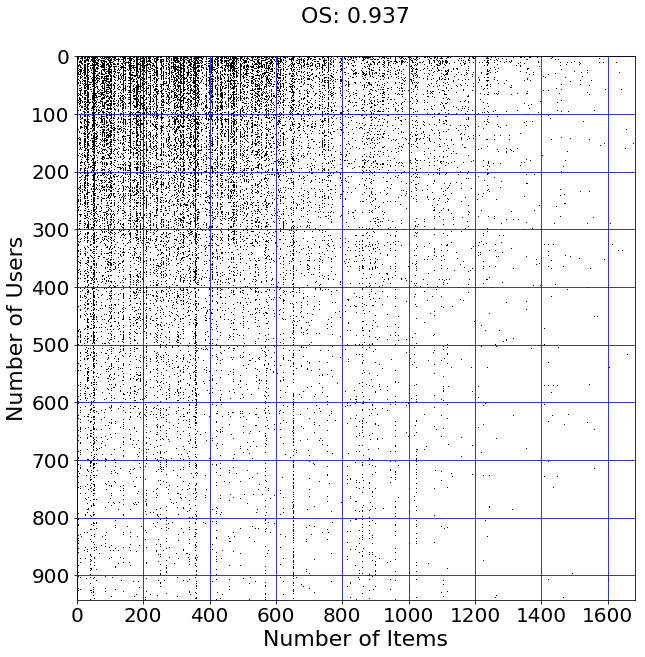

In [66]:
plot = plotUtilityMatrix(utility_matrix = R, title = 'Users Sorted Utility Matrix', figsize = (10,10), verbose = verbose)
savePlot(plot = plot, results_path = results_path, dataset = dataset, filename = 'usersSortedUtilityMatrix.png', verbose = verbose)

<h2>Sorting Items</h2>

<p>We then move to sorting our items given the following item specific sparsity measure (ISS) as follows: 
<p> $ISS = 1 - \frac{n_i}{\max{i \in I} (n_i)}$
<p>where $n_i$ is the amount of evaluations a specific user $u$ has given $I$.

In [17]:
%%time
#########################################################
# Run this cell if you want to reset
# the utility matrix
#########################################################


R, usersIds, itemsIds = LoadUtilityMatrix(df_ratings = df_ratings, verbose = verbose)

itemsSparsity, itemsSortedFlag = InitializeUsersSparsity(R)

In [70]:
%%time

# Initializing Items Sparsity Array
itemsSparsity, itemsSortedFlag = InitializeItemsSparsity(R)    


CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 22.2 µs


In [78]:
%%time

# Sorting Items by Sparsity
time_zero = time.time();

# Calculating users specific sparsity array
itemsSparsity, itemsSortedFlag = calculateItemsSpecificSparsityMeasure(utility_matrix = R, verbose = verbose)
 
# Saving ISS Variables
saveVariable(results_path, dataset, filename = 'itemsSparsityArray', variable = usersSparsity, verbose = verbose)

R, itemsIds = sortItemsBySparsity(utility_matrix = R, itemsIds = itemsIds, itemsSparsity = itemsSparsity, itemsSortedFlag = True, verbose = verbose)


[*] Saving variable to ./Results/Variables/100k/itemsSparsityArray file
[*] Removing existing file
[+] File saved.
[*] Skipping calculation of ISS array
[*] Sorting Items by ISS
CPU times: user 31.1 ms, sys: 899 µs, total: 32 ms
Wall time: 91 ms


<h3>Visualizing Items-Sorted Utility Matrix</h3>

[*] Saving plot to {} folder ./Results/Figures/100k/itemsAndUsersSortedUtilityMatrix.png
[+] Results saved.


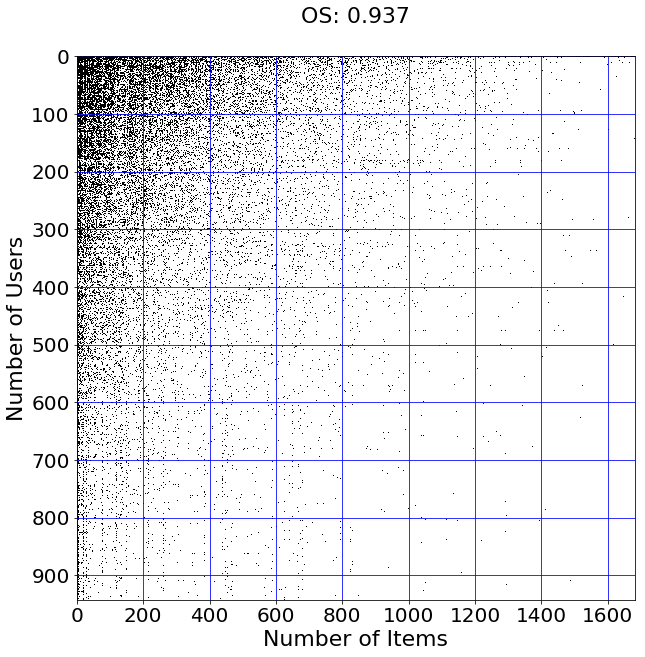

In [79]:
plot = plotUtilityMatrix(utility_matrix = R, title = 'Users and Items Sorted Utility Matrix', figsize = (10,10), verbose = verbose)
savePlot(plot = plot, results_path = results_path, dataset = dataset, filename = 'itemsAndUsersSortedUtilityMatrix.png', verbose = verbose)

<h2>Creating Utility Matrix Back-up</h2>
In case you want to go back to an utility matrix state, use the cells below

In [20]:
########################################################
# Creating back-up! Run this cell only if you want to 
# save your current utility matrix state.
########################################################
time_zero = time.time()

R_copy = np.copy(R);
print "Utility Matrix Copy Shape: ", R_copy.shape;
print "Elapsed time: ", time.time()-time_zero;

print R_copy

Utility Matrix Copy Shape:  (943, 1682)
Elapsed time:  0.00276398658752
[[ 5.  0.  0. ...,  0.  0.  0.]
 [ 4.  2.  3. ...,  0.  0.  3.]
 [ 5.  4.  5. ...,  0.  0.  0.]
 ..., 
 [ 5.  3.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  4.  0. ...,  0.  0.  0.]]


In [53]:
# Getting back-up point
time_zero = time.time();
R = np.copy(R_copy)
print "Utility Matrix shape: ", R.shape
print "Elapsed time: ", time.time()-time_zero;
print R;

Utility Matrix shape:  (943, 1682)
Elapsed time:  0.00705981254578
[[ 5.  0.  0. ...,  0.  0.  0.]
 [ 4.  2.  3. ...,  0.  0.  3.]
 [ 5.  4.  5. ...,  0.  0.  0.]
 ..., 
 [ 5.  3.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  4.  0. ...,  0.  0.  0.]]


<h1>Chopping Utility Matrix</h1>
In order to analyse how our overall sparsity changes by reducing users or items, we can chop our utility matrix according to 2 strategies:
- Chopping Users/Items by Specific Sparsity: we will only maintain those users/items with specific sparsity less than a defined threshold;
- Chopping Users/Items by Quantity: we will only maintain a certain amount of users/items according to our desired utility matrix shape.

In [101]:
# Auxiliary Functions
def chopUsersByUSS(utility_matrix, uss, usersIds = None, verbose = False):
    """Returns utility matrix after dropping users with USS greater than 
    the last USS (considering utility matrix sorted by users)."""  

    # If uss is negative, return only the first user
    if uss <= 0:
        if (verbose):
            print ("USS = {} lower than 0 - returning only the first users".format(uss))            
            
        if usersIds is None:
            if (verbose):
                print ("Users Ids not passed - returning only utility matrix")        
            return utility_matrix[0:1]
        else:
            if (verbose):
                print ("Users Ids - returning utility matrix and current users Ids")        
            return utility_matrix[0:1], usersIds[0:1]
        
    # If uss is greater than 1, return all users
    if uss >= 1:
        if (verbose):
            print ("USS = {} greater than 1 - returning all users".format(uss))            
            
        if usersIds is None:
            if (verbose):
                print ("Users Ids not passed - returning only utility matrix")        
            return utility_matrix
        else:
            if (verbose):
                print ("Users Ids - returning utility matrix and current users Ids")        
            return utility_matrix, usersIds   
    
    usersSparsityArray, _ = calculateUsersSpecificSparsityMeasure(utility_matrix, verbose = verbose)
    usersSparsityArray = np.sort(usersSparsityArray);       
        
    if uss > usersSparsityArray[-1]:             
        
        if usersIds is None:
            if (verbose):
                print ("Users Ids not passed - returning only utility matrix")        
            return utility_matrix
        else:
            if (verbose):
                print ("Users Ids - returning utility matrix and current users Ids")        
            return utility_matrix, usersIds          
    
    lastUserIndex = np.argmax(usersSparsityArray >= uss)           
    
    if (verbose):
        print ("Last User Index to be kept: {}".format(lastUserIndex))
    
    if usersIds is None:
        if (verbose):
            print ("Users Ids not passed - returning only utility matrix")        
        return utility_matrix[:lastUserIndex]
    else:
        if (verbose):
            print ("Users Ids - returning utility matrix and new users Ids")        
        return utility_matrix[:lastUserIndex], usersIds[:lastUserIndex] 

def chopItemsByISS(utility_matrix, iss, itemsIds = None, verbose = False):
    """Returns utility matrix after dropping items with ISS greater than 
    the last ISS."""
    
    if iss >= 1: # If iss >= 1, return original matrix
        if (verbose):
            print ("ISS = {} greater than 1 - returning all items".format(iss))
            
        if (itemsIds is not None):
            if (verbose):
                print ("Items Ids passed - returning utility matrix and current items Ids")        
            return utility_matrix, itemsIds
        else:
            if (verbose):
                print ("Items Ids not passed - returning only utility matrix")        
            return utility_matrix
        
    if iss <= 0: # If iss <= 0, return only the first item
        if (verbose):
            print ("ISS = {} lower than 0 - returning only the first items".format(iss))
            
        tempMatrix = np.array(utility_matrix[:,0])
        tempMatrix = np.reshape(tempMatrix, (utility_matrix.shape[0],1))
        
        if (itemsIds is not None):
            if (verbose):
                print ("Items Ids passed - returning utility matrix and current items Ids")        
            return tempMatrix, itemsIds
        else:
            if (verbose):
                print ("Items Ids not passed - returning only utility matrix")        
            return tempMatrix

    # If iss between 0 and 1, continue the calculations    
    itemsSparsityArray, _ = calculateItemsSpecificSparsityMeasure(utility_matrix);    
    itemsSparsityArray = np.sort(itemsSparsityArray);        
    
    # If iss limit is greater than the last item's iss, return the original matrix
    if iss > itemsSparsityArray[-1]:
        
        if (verbose):
            print ("ISS = {} greater than last item's ISS = {} - returning all items".format(iss, itemsSparsityArray[-1]))
            
        if (itemsIds is not None):
            if (verbose):
                print ("Items Ids passed - returning utility matrix and current items Ids")        
            return utility_matrix, itemsIds
        else:
            if (verbose):
                print ("Items Ids not passed - returning only utility matrix")        
            return utility_matrix
     
    lastItemIndex = np.argmax(itemsSparsityArray >= iss);
    
    if (verbose):
        print ("Last Item Index to be kept: {}".format(lastItemIndex))
    
    tempMatrix = np.array(utility_matrix[:,:lastItemIndex]);
    
    if lastItemIndex == 0:        
        tempMatrix = np.reshape(tempMatrix, (utility_matrix.shape[0],1));
        
    # Checking if user passed items Ids to be chopped as well
    if (itemsIds is not None):
        if (verbose):
            print ("Items Ids passed - returning utility matrix and new items Ids")        
        return tempMatrix, itemsIds[:lastItemIndex]
    else:
        if (verbose):
            print ("Items Ids not passed - returning only utility matrix")        
        return tempMatrix
    
    
# Tests
#chopUsersByUSS(utility_matrix = R, uss = 1, usersIds = usersIds, verbose = verbose)
#chopItemsByISS(utility_matrix = R, iss = 1, itemsIds = itemsIds, verbose = verbose)
    
#@np.vectorize    
def calculateOverallSparsityBySpecific(utility_matrix, uss, iss, verbose = False):
    """Calculates OS after chopping utility matrix given the last user's 
    and item's specific sparsity."""
    if (verbose):
        print ("[*] Calculating Overall Sparsity due to Specific Sparsity Chops")
        
    # Chopping utility matrix    
    utility_matrix = chopUsersByUSS(utility_matrix = utility_matrix, uss = uss, usersIds = None, verbose = verbose)
    utility_matrix = chopItemsByISS(utility_matrix = utility_matrix, iss = iss, itemsIds = None, verbose = verbose)
    
    # Calculating chopped utility matrix overall sparsity
    result = calculateOverallSparsityMeasure(utility_matrix)
    
    return result;    

# calculateOverallSparsityBySpecific(utility_matrix = R, uss = 0.5, iss = 1, verbose = False)

<h2>Analysing Users Quantity given USS threshold</h2>
What happens to our users amount if we only keep those users with USS value less than a specific threshold ?

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  3543.62874913
CPU times: user 1.57 s, sys: 88.2 ms, total: 1.66 s
Wall time: 5.27 s


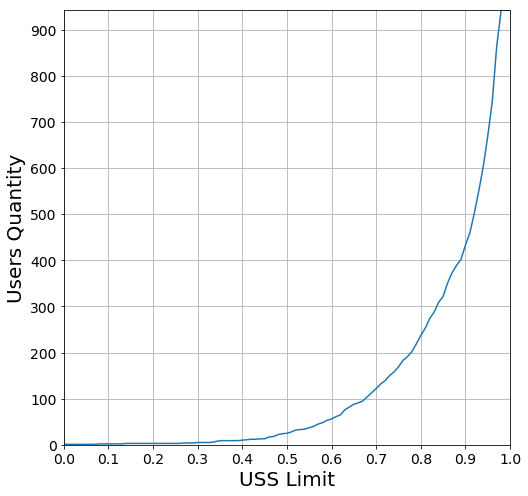

In [102]:
%%time

sparsityChops = np.array([x/100.0 for x in xrange(0, 101, 1)])

usersQuantity = []
for sparsity_limit in sparsityChops:   
    chopedMatrix = chopUsersByUSS(utility_matrix = R, uss = sparsity_limit, usersIds = None, verbose = False)    
    usersQuantity.append(chopedMatrix.shape[0]);

    
#plt.plot(sparsityChops, usersQuantity, '-')
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(sparsityChops, usersQuantity)
ax.axis([0, sparsityChops[-1], 0, usersQuantity[-1]])
ax.grid(True)
ax.set_xticks([x/100.0 for x in xrange (0, 110, 10)])
ax.set_yticks([x for x in xrange (0, usersQuantity[-1], 100)])
ax.set_xlabel('USS Threshold', fontsize = 20)
ax.set_ylabel('Users Quantity', fontsize = 20)
#ax.set_title('Users Quantity x Users Sparsity Limit', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=14)

savePlot(plot = plot, results_path = results_path, dataset = dataset, filename = 'usersSortedUtilityMatrix.png', verbose = verbose)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'usersQuantityXusersSparsity.png')
print "[+] Results saved.";

<h2>Analysing Items Quantity given ISS threshold</h2>
What happens to our items amount if we only keep those items with ISS value less than a specific threshold ?

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
CPU times: user 839 ms, sys: 64.4 ms, total: 903 ms
Wall time: 2.92 s


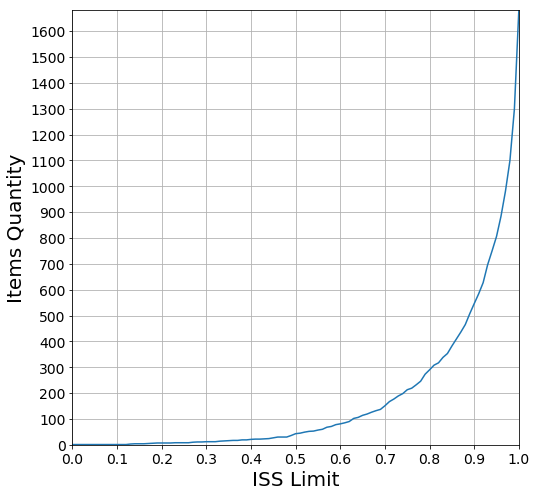

In [106]:
%%time

sparsityChops = np.array([x/100.0 for x in xrange(0, 101, 1)])

itemsQuantity = []
for sparsity_limit in sparsityChops:
    chopedMatrix = chopItemsByISS(utility_matrix = R, iss = sparsity_limit, itemsIds = None, verbose = False)    
    itemsQuantity.append(chopedMatrix.shape[1])

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(sparsityChops, itemsQuantity)
ax.axis([0, sparsityChops[-1], 0, itemsQuantity[-1]])
ax.grid(True)
ax.set_xticks([x/100.0 for x in xrange (0, 110, 10)])
ax.set_yticks([x for x in xrange (0, itemsQuantity[-1], 100)])

ax.set_xlabel('ISS Limit', fontsize = 20)
ax.set_ylabel('Items Quantity', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=14)
#ax.set_title('Items Quantity x Items Sparsity Limit', fontsize = 15)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'itemsQuantityXitemsSparsity.png')
print "[+] Results saved.";


<h2>Analyzing Specific Sparsity Limit to have Given Number of Users/Items</h2>

In [56]:
%%time
# Getting Users Quantity by Sparsity

usersQuantityThreshold = 900;

sparsityChops = np.array([x/100.0 for x in xrange(0, 101, 1)])
for sparsity_limit in sparsityChops:    
    chopedMatrix = chopUsersByUSS(chopedMatrix, sparsityLimit);
    if chopedMatrix.shape[0] > usersQuantityThreshold:
        break;
    
print "USS limit to have ", usersQuantityThreshold, " users: ", sparsityLimit;
print "Number of users: ", chopedMatrix.shape[0];

USS limit to have  900  users:  0.98
Number of users:  943
Elapsed time:  1.17929792404


In [58]:
# Getting Items Quantity by Sparsity
time_zero = time.time();

itemsQuantityThreshold = 900;

sparsityChops = np.array([x/100.0 for x in xrange(0, 101, 1)])
for sparsityLimit in sparsityChops:
    chopedMatrix = np.copy(R);
    chopedMatrix = chopItemsByISS(chopedMatrix, sparsityLimit);
    if chopedMatrix.shape[1] > itemsQuantityThreshold:
        break;
    
print "ISS limit to have ", itemsQuantityThreshold, " items: ", sparsityLimit;
print "Number of items: ", chopedMatrix.shape[1];
print "Elapsed time: ", time.time()-time_zero;

ISS limit to have  900  items:  0.97
Number of items:  981
Elapsed time:  1.48077297211


<h2>Chopping Utility Matrix by Specific Sparsity</h2>
What happens to our utility matrix OS if we chop items and/or users by their specific sparsity?

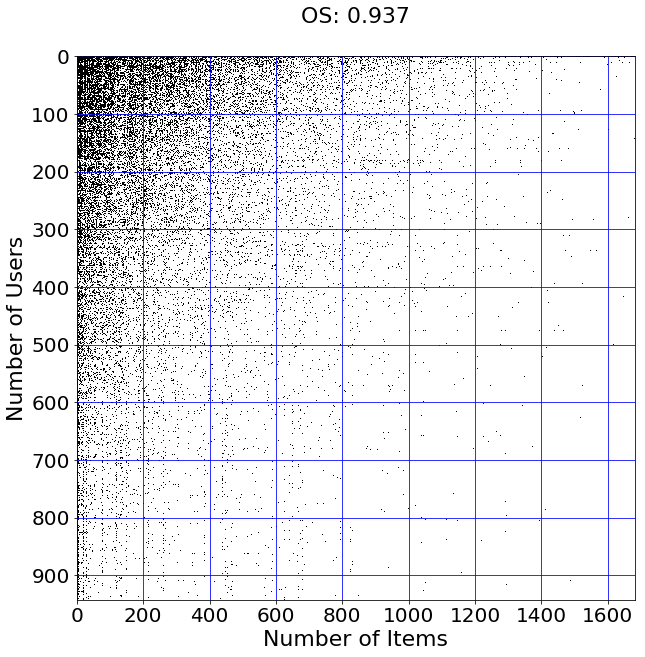

In [117]:
# Visualizing Items Sorted Matrix Sparsity
time_zero = time.time();

%matplotlib inline

usersUSSlimit = 1.0
itemsISSlimit = 1.0

chopedMatrix = chopUsersByUSS(utility_matrix = R, uss = usersUSSlimit, usersIds = None, verbose = False) 
chopedMatrix = chopItemsByISS(utility_matrix = chopedMatrix, iss = itemsISSlimit, itemsIds = None, verbose = False) 

plot = plotUtilityMatrix(utility_matrix = chopedMatrix, title = 'Users and Items Choped Utility Matrix', figsize = (10,10), verbose = verbose)

<h3>Visualizing OS effect due to Specific Sparsity changes</h3>

In [175]:
%%time
step_size = 1

X = np.array([x/100.0 for x in xrange(1, 100, step_size)]) # Starts with lower USS and keeps increasing
Y = np.array([y/100.0 for y in xrange(1, 100, step_size)]) # Starts with high ISS and keeps decreasing

X, Y = np.meshgrid(X, Y)

Z = np.zeros([X.shape[0], Y.shape[1]])

for ix_x in np.arange(X.shape[0]):
    for ix_y in np.arange(Y.shape[1]):            
        Z[ix_x][ix_y] = calculateOverallSparsityBySpecific(utility_matrix = R, uss = Y[ix_x][ix_y], iss = X[ix_x][ix_y], verbose = False)
    
#print Z

CPU times: user 1min 53s, sys: 931 µs, total: 1min 53s
Wall time: 1min 54s


In [189]:
from functools import partial
partial_f = partial(calculateOverallSparsityBySpecific, utility_matrix = R, verbose = False)

#@np.vectorize
#partial_f = partial_f

partial_f(uss = 0.26, iss = 0.26)

@np.vectorize
def vec_f (uss, iss):
    return partial_calculateOverallSparsityBySpecific(uss = uss, iss = iss)

#Z = vec_f(uss = X, iss = Y)


#Plotting 2-D evaluation graph

granularity = 1

# Make data.
A = np.array([a/100.0 for a in xrange(1,100,granularity)])
B = np.array([b/100.0 for b in xrange(1,100,granularity)])

A, B = np.meshgrid(A, B)

#Processing data
Z = vec_f(A, B);



#@np.vectorize    
#def calculateOverallSparsityBySpecific(utility_matrix, uss, iss, verbose = False):

#calculateOverallSparsityBySpecific(utility_matrix = R, uss = 0.36, iss = 0.16, verbose = False)

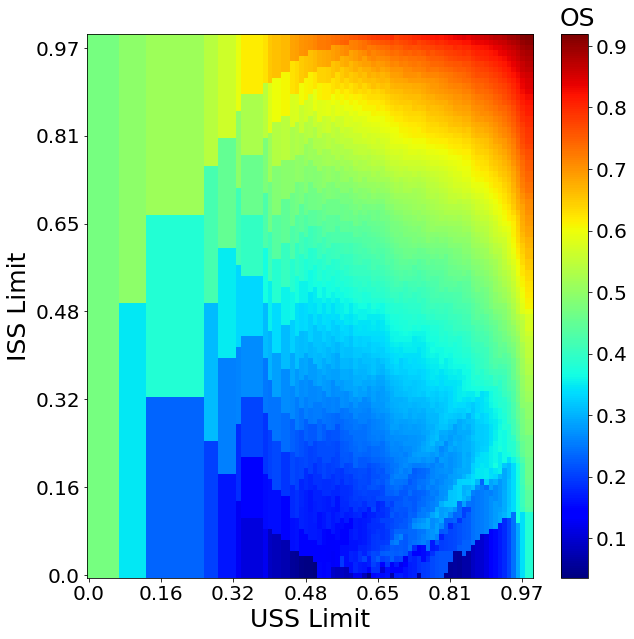

In [190]:

A = np.array([a/100.0 for a in xrange(0,100,step_size)])
B = np.array([b/100.0 for b in xrange(0,100,step_size)])

fig, ax = plt.subplots(figsize=(10,10))

cax = ax.imshow(Z[:,:], cmap="jet", aspect="auto")
plt.gca().invert_yaxis()

numberOfTicks = 6

labels = [x/float(Z.shape[0]) for x in xrange(0,Z.shape[0],Z.shape[0]/numberOfTicks)]
for l in xrange(len(labels)):
    labels[l] = float("{0:.2f}".format(labels[l]))
    
plt.xticks(np.arange(0, Z.shape[0], Z.shape[0]/numberOfTicks))
plt.yticks(np.arange(0, Z.shape[1], Z.shape[0]/numberOfTicks))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Setting Labels
tick_fontsize = 20
label_fontsize = 25
ax.set_xlabel('USS Limit', fontsize = label_fontsize)
ax.set_ylabel('ISS Limit', fontsize = label_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

cbar = fig.colorbar(cax)
cbar.set_label('OS', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)
cbar.ax.tick_params(labelsize = tick_fontsize)



# Saving figure
#filename = '2d-ISSxUSSxOS.png';
#fullpath = results_path+'Figures/'+dataset+filename;
#print "[*] Saving " + filename + " figure to " + results_path+'Figures/'+dataset + " folder..."
#plt.savefig(fullpath);
#print "[+] Results saved.";

In [149]:
granularity = 5

X = np.array([a/100.0 for a in xrange(0,101, granularity)]) # user
Y = np.array([b/100.0 for b in xrange(100,-1, -granularity)]) # item
#print X
#print Y

Zline = np.array([])
firstLine = True

for y in xrange(len(Y)):
    Zline = np.array([]);
    for x in xrange(len(X)):
        element = calculateOverallSparsityBySpecific (X[x], Y[y]); #user, item
        Zline = np.append(Zline, element)
    if firstLine:
        Z = np.array([Zline])
        firstLine = False
    else:
        Z = np.append(Z, [Zline], axis = 0)    
    
    #print Zline
#print Zline.shape
print Z.shape
#print Z

(21, 21)


In [187]:
#Plotting 2-D evaluation graph

granularity = 1

# Make data.
A = np.array([a/100.0 for a in xrange(1,100,granularity)])
B = np.array([b/100.0 for b in xrange(1,100,granularity)])

A, B = np.meshgrid(A, B)

#Processing data
Z = calculateOverallSparsityBySpecific (A, B);


[*] Saving 2d-ISSxUSSxOS.png figure to ./Results/Figures/100k/ folder...
[+] Results saved.


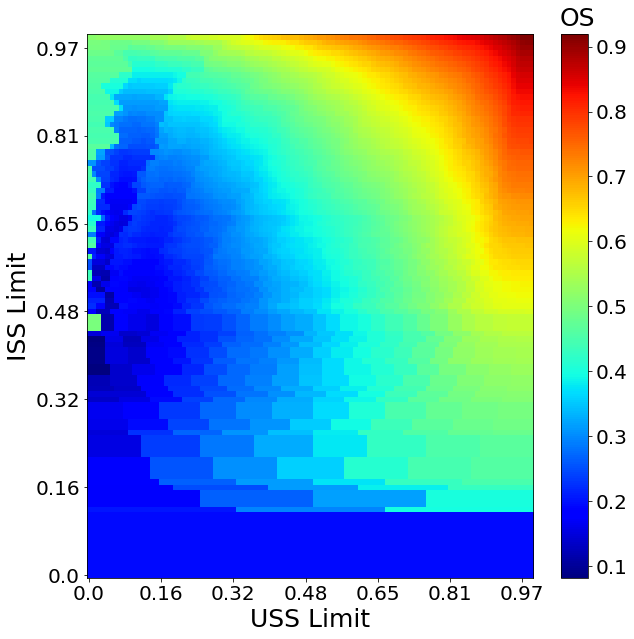

In [228]:
%matplotlib inline

A = np.array([a/100.0 for a in xrange(0,100,granularity)])
B = np.array([b/100.0 for b in xrange(0,100,granularity)])

fig, ax = plt.subplots(figsize=(10,10))

cax = ax.imshow(Z[:,:], cmap="jet", aspect="auto")
plt.gca().invert_yaxis()

numberOfTicks = 6

labels = [x/float(Z.shape[0]) for x in xrange(0,Z.shape[0],Z.shape[0]/numberOfTicks)]
for l in xrange(len(labels)):
    labels[l] = float("{0:.2f}".format(labels[l]))
    
plt.xticks(np.arange(0, Z.shape[0], Z.shape[0]/numberOfTicks))
plt.yticks(np.arange(0, Z.shape[1], Z.shape[0]/numberOfTicks))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Setting Labels
tick_fontsize = 20
label_fontsize = 25
ax.set_xlabel('USS Limit', fontsize = label_fontsize)
ax.set_ylabel('ISS Limit', fontsize = label_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

cbar = fig.colorbar(cax)
cbar.set_label('OS', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)
cbar.ax.tick_params(labelsize = tick_fontsize)



# Saving figure
filename = '2d-ISSxUSSxOS.png';
fullpath = results_path+'Figures/'+dataset+filename;
print "[*] Saving " + filename + " figure to " + results_path+'Figures/'+dataset + " folder..."
plt.savefig(fullpath);
print "[+] Results saved.";

<h1>Testing Algorithms According to Sparsity</h1>
Now that we've set how we can change our OS due to specific sparsities, we can analyse how a recommender system is affected if we work on a certain sparsity zone.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
#from surprise.accuracy import mae, rmse

class SAERecSys:

    def __init__(self, input_matrix,
                 numNeurons = 16,                  
                 loss_metric = 'mse',
                 learning_rate = 0.001):
        
        # Always call base method before doing anything.
        self.input_matrix = input_matrix;
        self.num_neurons = numNeurons;                        
        self.loss_metric = loss_metric;
        self.learning_rate = learning_rate;  
        self.cv_metrics_values = {};
        
        # Splitting train and test set
        #self.x_train, self.x_test = train_test_split(self.input_matrix);
        
    def fit(self, verbose = False):
        
        # Splitting train and test set
        self.x_train, self.x_test = train_test_split(self.input_matrix);
        
        # Scaling input to range (-1,1)
        self.xNormScaler = MinMaxScaler(feature_range = (-1,1))
        self.xNormScaler.fit(self.x_train)

        self.x_norm_train = self.xNormScaler.transform(self.x_train)
        self.x_norm_test = self.xNormScaler.transform(self.x_test)

        #Setting autoencoder
        self.inputDim = self.x_norm_train.shape[1] #Number of items

        self.autoencoder = Sequential([
                                  Dense(self.num_neurons, activation = 'selu', kernel_initializer = 'uniform', input_dim = self.inputDim),
                                  Dense(self.inputDim, activation = 'tanh', kernel_initializer = 'uniform')
                                 ])

        #SGD = optimizers.SGD(lr=0.5, momentum=0.00, decay=0.0, nesterov=False)
        #Adam = optimizers.Adam(lr=0.0005, decay = 0.00001)
        self.Adam = optimizers.Adam(lr = self.learning_rate)

        self.autoencoder.compile(optimizer = self.Adam, loss = self.loss_metric, metrics=['mae'])
        #autoencoder.summary()
        
        self.earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto')

        time_zero = time.time()

        self.fitHistory = self.autoencoder.fit(
                                    self.x_norm_train, 
                                    self.x_norm_train, 
                                    epochs = 2000,
                                    verbose = 0,
                                    shuffle = True,
                                    validation_data = (self.x_norm_test, self.x_norm_test), 
                                    callbacks = [self.earlyStopping])

        self.predicted_matrix = self.predict(self.input_matrix);
        
        
        #print('Time to fit model: '+str(time.time()-time_zero)+' seconds')
        
        return self    
        
    def cross_validate(self, n_folds = 10, metrics = ['rmse', 'mae', 'mrre'], verbose = True):
        for metric in metrics:
            self.cv_metrics_values[metric] = [];
        
        for i in xrange(n_folds):
            time_zero = time.time();
            self.fit(self.input_matrix);            
            fold_mae = self.evaluate('mae');
            fold_rmse = self.evaluate('rmse');
            fold_mrre = self.evaluate('mrre');
            self.cv_metrics_values['rmse'].append(fold_rmse)
            self.cv_metrics_values['mae'].append(fold_mae)
            self.cv_metrics_values['mrre'].append(fold_mrre)
            
            
            #print "Elapsed time for fold " + str(i) + ": ", time.time()-time_zero;
        
        return self.cv_metrics_values;
        
    def evaluate(self, metric = 'rmse'):
        
        if metric == 'rmse':
            return np.sqrt(mean_squared_error(self.x_test, self.predict(self.x_test)));
        elif metric == 'mae':
            return mean_absolute_error (self.x_test, self.predict(self.x_test));
        elif metric == 'mrre':
            return MRRE(self.x_test, self.predict(self.x_test))
        
        else:
            return "Invalid Metric: " + str(metric);
        
        
    def predict(self, matrix):
        # Creating scaler model
        matrix_norm_scaler = MinMaxScaler(feature_range = (-1,1));        
        
        # Fitting scaler model
        matrix_norm_scaler.fit(matrix);        
        
        # Creating normalized matrix
        matrix_norm = matrix_norm_scaler.transform(matrix);

        # Predicting output for normalized input matrix
        output = self.autoencoder.predict(matrix_norm);

        # Denormalizing output
        output_denormal = matrix_norm_scaler.inverse_transform(output);

        # Rounding denormalized output to nearest integer
        matrix_predicted = np.rint(output_denormal);
        
        return matrix_predicted

        #print R_predicted
        
    def estimate(self, u, i): # Estimates an evaluation from a given user to an item        
        return self.predicted_matrix[u][i]
    


Using TensorFlow backend.


<h3>Auxiliary Function</h3>

In [24]:
#Importing Libs
from surprise import NMF
from surprise import SVD
from surprise import KNNBasic
from surprise import Dataset
from surprise import evaluate, print_perf
from sklearn.model_selection import train_test_split

import surprise
#Creating dataset to use in surprise lib format

def MRRE(matrix, predicted_matrix):
    sum_error = 0;
    eval_quantity = 0;
        
    if len(matrix.shape) == 1:
        for i in xrange(len(matrix)):        
            if matrix[i] != 0:                
                sum_error += (matrix[i]-predicted_matrix[i])**2;
                eval_quantity += 1;
    
        return np.sqrt(sum_error/float(eval_quantity));
        
    
    for i in xrange(len(matrix)):
        for j in xrange(len(matrix[i])):
            if matrix[i][j] != 0:                
                sum_error += (matrix[i][j]-predicted_matrix[i][j])**2;
                eval_quantity += 1;
    
    return np.sqrt(sum_error/float(eval_quantity));


###################################################################
# Keep in mind the number of folds used in cross validation!
###################################################################

def getAlgorithmEvaluations(algorithmName, USSLimit, ISSLimit, number_of_folds = 10, number_of_epochs = 20):
    algorithms = [KNNBasic(),  SVD(n_epochs = number_of_epochs), NMF()];
    algorithmsNames = np.array(['KNNBasic', 'SVD', 'NMF', 'SAE']);
    
    if algorithmName not in algorithmsNames:
        print algorithmName, " is not on the algorithms list.";
        return -1;
    
    global R;
    chopedMatrix = np.copy(R);
    chopedMatrix = chopUsersByUSS(chopedMatrix, USSLimit);
    chopedMatrix = chopItemsByISS(chopedMatrix, ISSLimit);

    OS = calculateOverallSparsityMeasure(chopedMatrix);
    shape = chopedMatrix.shape;
    
    if algorithmName in ['SVD', 'NMF']:
    
        df = createUtilityMatrixPandasDataset(chopedMatrix);

        tempFilePath = results_path+'Variables/'+'tempData.csv';
        with open(tempFilePath, "w") as fout:
            head = 'userId,movieId,rating\n';
            fout.write(head);
            for registerCount in xrange(df.shape[0]):
                line = str(df['userId'][registerCount])+','+str(df['movieId'][registerCount])+','+str(df['rating'][registerCount])+'\n';
                fout.write(line);

        r = surprise.dataset.Reader(sep=',', skip_lines=1);
        data = Dataset.load_from_file(tempFilePath, r);    
        data.split(n_folds=number_of_folds)

        # Evaluate performances of our algorithm on the dataset.
        algo = algorithms[np.where(algorithmsNames == algorithmName)[0][0]];

        perf = evaluate(algo, data, measures=['RMSE', 'MAE'], verbose=0)
        
        maeMeans = np.mean(perf['MAE'])
        maeStd = np.std(perf['MAE'])
        rmseMeans = np.mean(perf['RMSE'])
        rmseStd = np.std(perf['RMSE'])
        
        #trainset, testset = train_test_split(data)
        #algo.fit(trainset)
        #prediction = algo.test(testset)
            
        #print algo.predict
            
        #global moviesIds;
        #bestUserPrediction = [];
        
        #num_eval = 0;
        #est_sum = 0;
        #for itemDatafileIndex in xrange(len(chopedMatrix[0])):            
        #    est_sum +=  (algo.predict(df["userId"][0],df["movieId"][itemDatafileIndex], r_ui = int(df["rating"][itemDatafileIndex])))[3]
        #    num_eval += 1;
            
        #print algo.predict(df["userId"][0],df["movieId"][itemDatafileIndex], r_ui = int(df["rating"][itemDatafileIndex]))
        #print est_sum/num_eval;
        #print bestUserPrediction
        #mrre = MRRE(bestUser, bestUserPrediction);
    
    elif algorithmName in ['SAE']:
        SAE_RS = SAERecSys(chopedMatrix);
        SAE_RS.cross_validate();
        maeMeans = np.mean(SAE_RS.cv_metrics_values['mae']);
        maeStd = np.std(SAE_RS.cv_metrics_values['mae']);
        rmseMeans = np.mean(SAE_RS.cv_metrics_values['rmse']);
        rmseStd = np.std(SAE_RS.cv_metrics_values['rmse']);
        #mrre = MRRE(chopedMatrix[0], SAE_RS.predict(chopedMatrix[0]));
        
    else:
        return "Unsuported Algorithm: " + algorithmName;
    
    returnArray = [algorithmName, USSLimit, ISSLimit, shape[0], shape[1], OS, maeMeans, maeStd, rmseMeans, rmseStd];
    
    return returnArray;


In [25]:
print getAlgorithmEvaluations('SVD', 0.5, 0.5);

['SVD', 0.5, 0.5, 25, 328, 0.34304878048780485, 0.71685165507172788, 0.023725170794411412, 0.91526631925147961, 0.032242832886626938]


In [31]:
print getAlgorithmEvaluations('SAE', 0.6, 0.6);

['SAE', 0.6, 0.6, 56, 377, 0.419145509662751, 1.2122205380826072, 0.042588371953146208, 1.5994852348542512, 0.049462397490867727]


In [32]:

print getAlgorithmEvaluations('SAE', 0.5, 0.5);
#print len(moviesIds)


['SAE', 0.5, 0.5, 25, 328, 0.34304878048780485, 1.2341027874564456, 0.047934048937114997, 1.5875817795334879, 0.037478671061994095]


In [33]:
print getAlgorithmEvaluations('SAE', 0.4, 0.4);

['SAE', 0.4, 0.4, 10, 251, 0.250199203187251, 1.0686586985391768, 0.10067951469149428, 1.41291527926627, 0.11560695796015398]


In [34]:
print getAlgorithmEvaluations('SAE', 0.3, 0.3);

['SAE', 0.3, 0.3, 5, 274, 0.256934306569343, 0.94142335766423346, 0.044109655739389894, 1.324679840103792, 0.069963233696760538]


In [36]:
print getAlgorithmEvaluations('SAE', 0.2, 0.2);

['SAE', 0.2, 0.2, 3, 185, 0.2324324324324324, 0.25297297297297294, 0.050290609079407599, 0.50025487327217599, 0.052134774770896487]


<h2>Getting Number of Epochs for SVD</h2>

In [ ]:
epochs = [e for e in xrange(10,201,10)]

RESULTS = []
TIMES = []

for epoch in epochs:
    time_zero = time.time()
    RESULT = getAlgorithmEvaluations('SVD',0.2,0.2,number_of_epochs = epoch)
    RESULTS.append(RESULT);
    TIMES.append(time.time()-time_zero)

saveVariable('RESULTS_EPOCH_STUDY', RESULTS)
saveVariable('EPOCHS_USED_IN_STUDY', epochs)
bot.sendMessage("Finished getting RMSE_SVD results for all epochs.");

In [ ]:

RMSE_SVD_EPOCHS = []
for result in RESULTS:
    RMSE_SVD_EPOCHS.append(result[8])

print RMSE_SVD_EPOCHS
    
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(epochs, RMSE_SVD_EPOCHS)
#ax.axis([0, RMSE_SVD_EPOCHS[-1], 0, epochs[-1]])
ax.grid(True)
#ax.set_xticks([x/100.0 for x in xrange (0, 110, 10)])
#ax.set_yticks([x for x in xrange (0, itemsQuantity[-1], 100)])

ax.set_xlabel('Epochs', fontsize = 20)
ax.set_ylabel('RMSE-SVD', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=14)
#ax.set_title('Items Quantity x Items Sparsity Limit', fontsize = 15)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'RMSE_SVD_EPOCHS.png')
print "[+] Results saved.";
bot.sendMessage("Finished getting results for all epochs.", results_path+'Figures/'+dataset+'RMSE_SVD_EPOCHS.png');

In [314]:
#Testing Functions
time_zero = time.time()
#print getAlgorithmEvaluations('NMF', 1.0, 1.0);
#print getAlgorithmEvaluations('SVD', 1.0, 1.0);
print getAlgorithmEvaluations('SAE', 1.0, 1.0);
print "Elapsed time: ", time.time()-time_zero

<surprise.dataset.DatasetAutoFolds instance at 0x4fc1b7a0>
['SVD', 1.0, 1.0, 944, 1683, 0.9370575143257097, 0.73290482700765724, 0.0048131266409736414, 0.93028300373413819, 0.0046881757594039661]
Elapsed time:  82.1655700207


In [311]:
#print getAlgorithmEvaluations('NMF', 0.9, 1.0);
print getAlgorithmEvaluations('SVD', 1.0, 1.0);
#print getAlgorithmEvaluations('SAE', 0.9, 1.0);

<surprise.dataset.DatasetAutoFolds instance at 0x5d5345a8>
['SVD', 1.0, 1.0, 944, 1683, 0.9370575143257097, 0.76362565529717963, 0.003278957261632378, 0.97498758506622174, 0.0040782683807064814]


In [315]:
#print getAlgorithmEvaluations('NMF', 0.6, 1.0);
#print getAlgorithmEvaluations('SVD', 0.6, 1.0);
print getAlgorithmEvaluations('SAE', 0.2, 0.2);

['SAE', 0.2, 0.2, 3, 185, 0.23423423423423428, 0.2094418763910289, 0.0089730748096246305, 0.71709644112497961, 0.013822272037180193]


In [198]:
#print getAlgorithmEvaluations('NMF', 1.0, 0.9);
print getAlgorithmEvaluations('SVD', 1.0, 0.9);
#print getAlgorithmEvaluations('SAE', 1.0, 0.9);

<surprise.dataset.DatasetAutoFolds instance at 0x64594098>
['SVD', 1.0, 0.9, 944, 546, 0.8435501645247407, 0.71754279654365938, 0.0077949559481116353, 0.91253676464329148, 0.01132065088221504]


In [199]:
#print getAlgorithmEvaluations('NMF', 1.0, 0.6);
print getAlgorithmEvaluations('SVD', 1.0, 0.6);
#print getAlgorithmEvaluations('SAE', 1.0, 0.6);

<surprise.dataset.DatasetAutoFolds instance at 0x6d72dcb0>
['SVD', 1.0, 0.6, 944, 81, 0.6640772128060264, 0.71322086854857913, 0.01073559289915357, 0.91156142656071848, 0.014520132936095715]


In [195]:
#print getAlgorithmEvaluations('NMF', 0.9, 0.9);
#print getAlgorithmEvaluations('SVD', 0.9, 0.9);
print getAlgorithmEvaluations('SAE', 0.9, 0.9);

['SAE', 0.9, 0.9, 433, 658, 0.7597555753666019, 0.21024326011863398, 0.0078398624183559189, 0.71884664272470622, 0.011871422459248769]


In [196]:
#print getAlgorithmEvaluations('NMF', 0.6, 0.6);
#print getAlgorithmEvaluations('SVD', 0.6, 0.6);
print getAlgorithmEvaluations('SAE', 0.6, 0.6);

['SAE', 0.6, 0.6, 56, 377, 0.41938234179613487, 0.21406286191929264, 0.0064898188573404448, 0.72442205580708419, 0.0090840519518120572]


<h3>Getting Algorithm Evaluations</h3>

In [26]:
bot = Bot('JFGS')
bot.sendMessage('oi')

In [37]:
#print algorithmsResults
filename = 'algorithmsResultsVector';
fullpath = results_path+'Variables/'+dataset+filename;
print "[*] Saving " + filename + " variable to " + fullpath
np.save(arr=algorithmsResults, file=fullpath)
print "[+] Results saved.";
bot.sendMessage('Results saved on file '+fullpath+'.npy')

[*] Saving algorithmsResultsVector variable to ./Results/Variables/100k/algorithmsResultsVector
[+] Results saved.


In [55]:
arr = np.array(np.load(fullpath+'.npy' ))

bot.sendMessage('Results succesfully loaded')

IOError: [Errno 2] No such file or directory: './Results/Figures/100k/2d-SAE-RMSE.png.npy'

In [ ]:
######################################################

time_zero = time.time();

#algorithmsNames = ['SVD', 'KNNBasic', 'NMF'];
algorithmsNames = ['SAE']; # Which algorithms you would like to evaluate
X = np.array([x/100.0 for x in xrange(5, 101, 50)]);
Y = np.array([x/100.0 for x in xrange(5, 101, 50)]);

Z_axis = np.zeros((len(X), len(Y)));


for alg in algorithmsNames:
    time_one = time.time();
    bot.sendMessage('Starting algorithm evaluation');
    
    for x_index in xrange(len(X)):
        bot.sendMessage('Starting x_index ' + x_index + '/' + len(X));    
        for y_index in xrange(len(Y)): 
            result = getAlgorithmEvaluations(alg, X[x_index], Y[y_index]);            
            Z_axis[x_index][y_index] = result[8];
    
    message = "Elapsed time for "+ str(alg) + ": "+ str(time.time()-time_one) + " s";
    print message;
    bot.sendMessage(message);
    var_Z_filename = 'Z_'+ alg + 'meshgrid_.csv'
    saveVariable(var_Z_filename, Z_axis);
    bot.sendMessage('Variable Sucessfully saved');

######################################################


In [ ]:
X_bkp = np.copy(X)
Y_bkp = np.copy(Y)
Z_bkp = np.copy(Z_axis)

In [73]:


for var, obj in locals().items():
    print var, sys.getsizeof(obj)

__ 96
telegram 56
_57 72
dataset_path 67
itemsISSLimits 112
Sequential 904
usersSparsity 7640
calculateItemsSpecificSparsityMeasure 120
KILO 24
moviesIds 13552
_i20 6128
ModelCheckpoint 904
_i59 72
MEGA 24
usersSortedFlag 24
_62 96
_61 96
fig 64
_i 92
alg 40
exit 64
evaluate 120
SVD 104
FillUtilityMatrix 120
os 56
surprise 56
X 256
_i50 5624
_sh 56
MRRE 120
usersUSSLimits 112
_i13 6612
_i12 1964
_i11 4120
_i10 2676
_i17 3808
_i16 3028
_i15 1996
_i14 716
x 24
_i19 1652
_i18 736
OS 24
_dh 80
arr 752
Dense 904
_i56 104
calculateUsersSpecificSparsityMeasure 120
InitializeItemsSparsity 120
result 152
_i72 92
MAE 120
saveVariable 120
Bot 104
itemsSortedFlag 24
filename 52
load_model 120
_i44 1268
train_test_split 120
_i28 4096
_i29 144
_i26 212
_i27 208
_i24 20988
_i25 332
_i22 8448
_i23 20644
var_Z_filename 80
_i21 1524
plt 56
_i48 104
_i49 136
calculateOverallSparsityBySpecific 64
__builtins__ 56
_i45 5628
_i46 5636
_i47 5628
_i40 296
_i41 1268
_i42 5628
_i43 296
InitializeUtilityMatrix 12

In [ ]:
var_Z_filename = './Results/Variables/100k/Z_'+ 'SAE' + 'meshgrid_.csv'
Z_axis = joblib.load(var_Z_filename)
#X = np.array([x/100.0 for x in xrange(5, 101, 1)]);
#Y = np.array([x/100.0 for x in xrange(5, 101, 1)]);
print Z_axis.shape
bot.sendMessage('Variable Loaded with dimensions '+str(Z_axis.shape));

[*] Saving 2d-SAE-RMSE.png figure to ./Results/Figures/100k/ folder...
[+] Results saved.


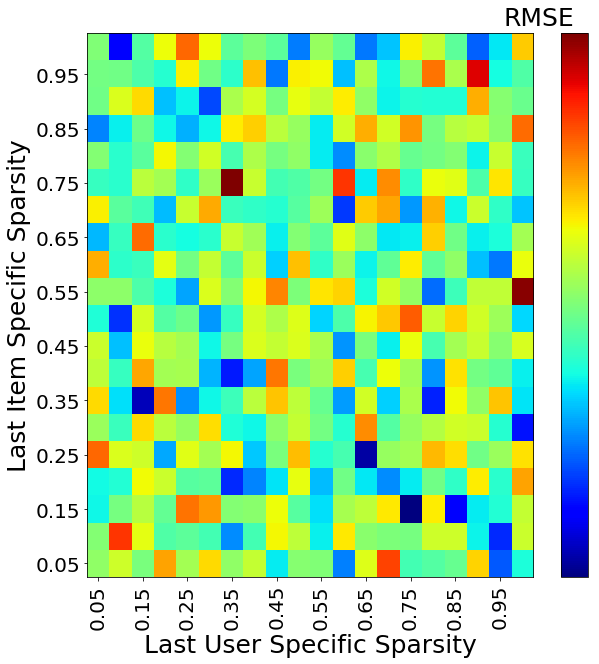

In [60]:
#Plotting 2-D evaluation graph
%matplotlib inline

algoName = 'SAE'
evaluationParameter = 'RMSE'
#cmapping = "viridis
#cmapping = "Spectral"
#cmapping = "seismic"
#cmapping = "CMRmap"
#cmapping = "CMRmap"
cmapping = "jet"

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(Z_axis[:,:], cmap=cmapping, aspect="auto")
plt.gca().invert_yaxis()

n_ticks = 10

plt.xticks(np.arange(0, len(X), len(X)/n_ticks))
plt.yticks(np.arange(0, len(Y), len(Y)/n_ticks))
X_ticks = [X[x] for x in xrange(0,len(X),len(X)/n_ticks)]
ax.set_xticklabels(X_ticks)
ax.set_yticklabels(X_ticks)

tick_fontsize = 20
label_fontsize = 25

# Setting Labels
ax.set_xlabel('Last User Specific Sparsity', fontsize = label_fontsize)
ax.set_ylabel('Last Item Specific Sparsity', fontsize = label_fontsize)
cbar = fig.colorbar(cax, ticks = [x/100.0 for x in xrange(0,1000,5)])

plt.xticks(rotation = 'vertical')
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
cbar.set_label('RMSE', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)
cbar.ax.tick_params(labelsize = tick_fontsize)

# Saving figure
filename = '2d-'+algoName+'-'+evaluationParameter+'.png';
fullpath = results_path+'Figures/'+dataset+filename;
print "[*] Saving " + filename + " figure to " + results_path+'Figures/'+dataset + " folder..."
plt.savefig(fullpath);
#bot.sendMessage('Grafico: ', fullpath)
print "[+] Results saved.";


In [ ]:
time_zero = time.time();

#algorithmsNames = ['SVD', 'KNNBasic', 'NMF'];
algorithmsNames = ['NMF']; # Which algorithms you would like to evaluate
usersUSSLimits = np.array([x/100.0 for x in xrange(10, 101, 2)]);
itemsISSLimits = np.array([x/100.0 for x in xrange(10, 101, 2)]);

algorithmsResults = [];
messages = []

for alg in algorithmsNames:
    
    bot.sendMessage('Starting algorithm evaluation');
    time_one = time.time();
    for userUSS in usersUSSLimits:
        message = '[' + str(time.time()-time_one) + '] Starting USS ' + str(userUSS)
        bot.sendMessage(message);
        for itemISS in itemsISSLimits: 
            message = '[' + str(time.time()-time_one) + '] Starting ISS ' + str(itemISS)
            bot.sendMessage(message);
            result = getAlgorithmEvaluations(alg, userUSS, itemISS)            
            algorithmsResults.append(result);
    
    message = "Elapsed time for "+ str(alg) + ": "+ str(time.time()-time_one) + " s";
    bot.sendMessage(message);
    print message
    #messages.append(message)
    #bot.sendMessage(messages)
    
algorithmsResults = np.array(algorithmsResults);

message = "Algorithms evaluations have finished. "
bot.sendMessage(message)
print "Elapsed time: ", time.time()-time_zero;

In [ ]:
#Creating dataframe to save evaluations and saving it to file.
algorithmsDataframe = pd.DataFrame()

#  algorithmsResults data:
#  [Algorithm, USSLimit, ISSLimit, shape[0], shape[1], OS, maeMeans, maeStd, rmseMeans, rmseStd];
algorithmsDataframe['Algorithm'] = algorithmsResults[:,0];
algorithmsDataframe['USS'] = algorithmsResults[:,1];
algorithmsDataframe['ISS'] = algorithmsResults[:,2];
algorithmsDataframe['users'] = algorithmsResults[:,3];
algorithmsDataframe['items'] = algorithmsResults[:,4];
algorithmsDataframe['OS'] = algorithmsResults[:,5];
algorithmsDataframe['MAEmeans'] = algorithmsResults[:,6];
algorithmsDataframe['MAEstd'] = algorithmsResults[:,7];
algorithmsDataframe['RMSEmeans'] = algorithmsResults[:,8];
algorithmsDataframe['RMSEstd'] = algorithmsResults[:,9];

path = results_path+'Variables/'+dataset+'NMF/'
filename = 'NMF-algorithmsResults.csv';
print "[*] Saving " + filename + " file to " + path + " folder..."
algorithmsDataframe.to_csv(path+filename);
message = 'AlgorithmsDataframe saved'
bot.sendMessage(message)
print "[+] Results saved."

In [ ]:

filename = 'algorithmsResults.csv'
fullpath = path+'SAE/'+'SAE-' + filename
print fullpath
algorithmsDataframe.to_csv(fullpath);

In [27]:
algorithmsDataframe = pd.read_csv(results_path+'Variables/'+dataset+'SVD/'+'SVD-algorithmsResults.csv')

In [28]:
print algorithmsDataframe.tail()
#print algorithmsDataframe.loc[np.argmin(algorithmsDataframe.RMSEmeans)]

     Unnamed: 0 Algorithm  USS   ISS  users  items        OS  MAEmeans  \
356         356       SVD  1.0  0.80    943    290  0.781808  0.709718   
357         357       SVD  1.0  0.85    943    382  0.808709  0.712696   
358         358       SVD  1.0  0.90    943    546  0.843384  0.717730   
359         359       SVD  1.0  0.95    943    806  0.879317  0.722607   
360         360       SVD  1.0  1.00    943   1682  0.936953  0.731654   

       MAEstd  RMSEmeans   RMSEstd  
356  0.007443   0.904332  0.009925  
357  0.008078   0.909146  0.007739  
358  0.005643   0.914215  0.007275  
359  0.005595   0.919267  0.008207  
360  0.007006   0.928689  0.007760  


In [208]:
time_zero = time.time()
ussProfiles = {
    'Very Tight': '0.68',
    'Tight' : '0.78',
    'Medium': '0.89',
    'Loose' : '0.97',
    'Very Loose': '0.98'}
ussProfilesNames = ['Very Tight', 'Tight', 'Medium', 'Loose', 'Very Loose']
issProfiles = {
    'Very Tight': '0.63',
    'Tight' : '0.75',
    'Medium': '0.86',
    'Loose' : '0.95',
    'Very Loose': '0.97'}
issProfilesNames = ['Very Tight', 'Tight', 'Medium', 'Loose', 'Very Loose']

print "=== SVD ===\n"    

for alg in algorithmsNames:
    print "\n",alg," - RMSE:"
    for uProfileName in ussProfilesNames:
        line = "\\textbf{"+uProfileName+"}";        
        for iProfileName in issProfilesNames:                        
            for register in xrange(len(algorithmsDataframe['Algorithm'])):
                if algorithmsDataframe['Algorithm'][register] == alg and algorithmsDataframe['USS'][register] == ussProfiles[uProfileName] and algorithmsDataframe['ISS'][register] == issProfiles[iProfileName]:
                    #print  uProfileName,'\t& ',iProfileName,'\t&\t$',algorithmsDataframe['RMSEmeans'][register][:5], '\pm',  algorithmsDataframe['RMSEstd'][register][:5],'$', '\\\\';
                    line = line + " & $" + algorithmsDataframe['RMSEmeans'][register][:5] + ' \pm ' +  algorithmsDataframe['RMSEstd'][register][:5]+'$'
        line = line + " \\\\"            
        print line
        
"""print "\n=== MAE ===\n"    
for alg in algorithmsNames:
    print alg," - MAE: "
    for uProfileName in ussProfiles:
        for iProfileName in issProfiles:
            for register in xrange(len(algorithmsDataframe['Algorithm'])):
                if algorithmsDataframe['Algorithm'][register] == alg and algorithmsDataframe['USS'][register] == ussProfiles[uProfileName] and algorithmsDataframe['ISS'][register] == issProfiles[iProfileName]:
                    print  uProfileName,'\t& ',iProfileName,'\t&\t$',algorithmsDataframe['MAEmeans'][register][:5], '\pm',  algorithmsDataframe['MAEstd'][register][:5],'$', '\\\\';
"""                 
print "Elapsed time: ", time.time()-time_zero;                    

=== SVD ===


SVD  - RMSE:
\textbf{Very Tight} \\
\textbf{Tight} \\
\textbf{Medium} \\
\textbf{Loose} \\
\textbf{Very Loose} \\
Elapsed time:  0.555946111679


<h2>Visualizing Algorihtms Evaluations</h2>

<h3> SAE - MAE</h3>

In [ ]:
# Making data arrays
A = np.array([])
B = np.array([])

Zline = np.array([])
algoName = 'SAE'
firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);
evaluationParameter = 'RMSEmeans'

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

#Z = np.append(Z, [Zline], axis = 0)


In [ ]:
#Plotting 2-D evaluation graph
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(Z[:,:], cmap="jet", aspect="auto")
plt.gca().invert_yaxis()

plt.xticks(np.arange(0, len(A), 1))
plt.yticks(np.arange(0, len(B), 1))
ax.set_xticklabels(A)
ax.set_yticklabels(B)

tick_fontsize = 20
label_fontsize = 25

# Setting Labels
ax.set_xlabel('Last User Specific Sparsity', fontsize = label_fontsize)
ax.set_ylabel('Last Item Specific Sparsity', fontsize = label_fontsize)
cbar = fig.colorbar(cax)

plt.xticks(rotation = 'vertical')
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
cbar.set_label('RMSE', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)
cbar.ax.tick_params(labelsize = tick_fontsize)

# Saving figure
filename = '2d-'+algoName+'-'+evaluationParameter+'.png';
fullpath = results_path+'Figures/'+dataset+filename;
print "[*] Saving " + filename + " figure to " + results_path+'Figures/'+dataset + " folder..."
plt.savefig(fullpath);
bot.sendMessage('Grafico: ', fullpath)
print "[+] Results saved.";


<h3>SVD - MAE</h3>

In [283]:
# Making data arrays
A = np.array([])
B = np.array([])

Zline = np.array([])
algoName = 'SVD'
firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);
evaluationParameter = 'RMSEmeans'

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)


In [256]:
bot = Bot('JFGS')


[*] Saving 2d-SVD-RMSEmeans.png figure to ./Results/Figures/100k/ folder...
[+] Results saved.


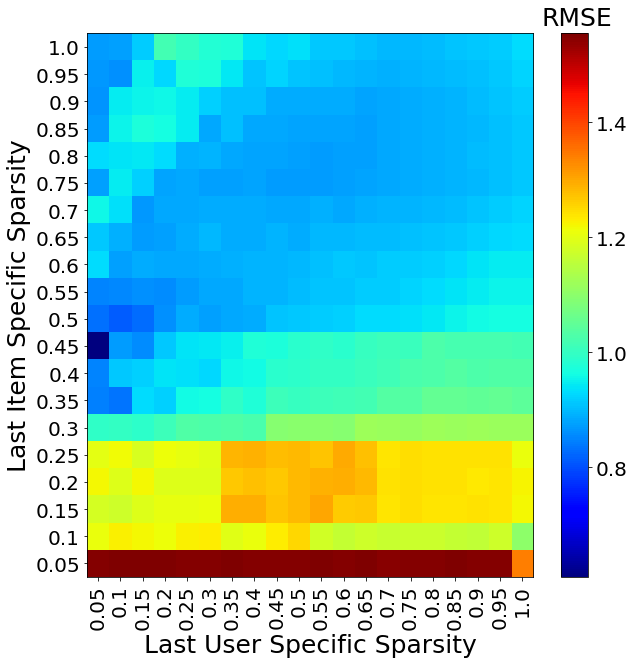

In [284]:
#Plotting 2-D evaluation graph
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(Z[:,:], cmap="jet", aspect="auto")
plt.gca().invert_yaxis()

plt.xticks(np.arange(0, len(A), 1))
plt.yticks(np.arange(0, len(B), 1))
ax.set_xticklabels(A)
ax.set_yticklabels(B)

tick_fontsize = 20
label_fontsize = 25

# Setting Labels
ax.set_xlabel('Last User Specific Sparsity', fontsize = label_fontsize)
ax.set_ylabel('Last Item Specific Sparsity', fontsize = label_fontsize)
cbar = fig.colorbar(cax)

plt.xticks(rotation = 'vertical')
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
cbar.set_label('RMSE', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)
cbar.ax.tick_params(labelsize = tick_fontsize)

# Saving figure
filename = '2d-'+algoName+'-'+evaluationParameter+'.png';
fullpath = results_path+'Figures/'+dataset+filename;
print "[*] Saving " + filename + " figure to " + results_path+'Figures/'+dataset + " folder..."
plt.savefig(fullpath);
bot.sendMessage('Grafico: ', fullpath)
print "[+] Results saved.";


[*] Saving variable to ./Results/Variables/100k/SVD-MAE-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/SVD-MAE-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/SVD-MAE-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.41921710968


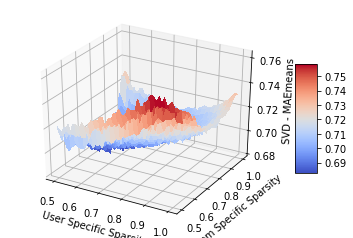

In [238]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

time_zero = time.time();

# Make data.
algoName = 'SVD'
evaluationParameter = 'MAEmeans'

A = np.array([])
B = np.array([])
#Z = np.array([[]])
Zline = np.array([])

firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)
A, B = np.meshgrid(A, B)

# Saving variables for future use
var_A_filename = 'SVD-MAE-A_meshgrid.csv'
var_B_filename = 'SVD-MAE-B_meshgrid.csv'
var_Z_filename = 'SVD-MAE-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')


#surf = ax.plot_surface(A, B, Z, rstride=1, cstride=1, cmap=cm.viridis)
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel(algoName+' - ' + evaluationParameter)

#plt.show()

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+algoName+'-'+evaluationParameter+'.png');
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;

<h3>SVD - RMSE</h3>

[*] Saving variable to ./Results/Variables/100k/SVD-RMSE-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/SVD-RMSE-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/SVD-RMSE-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.501820087433


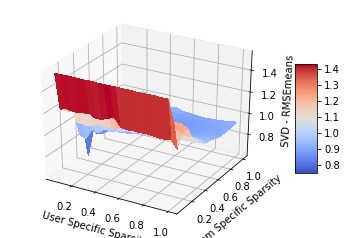

In [308]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

time_zero = time.time();

# Make data.
algoName = 'SVD'
evaluationParameter = 'RMSEmeans'

A = np.array([])
B = np.array([])
#Z = np.array([[]])
Zline = np.array([])

firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)
A, B = np.meshgrid(A, B)

# Saving variables for future use
var_A_filename = 'SVD-RMSE-A_meshgrid.csv'
var_B_filename = 'SVD-RMSE-B_meshgrid.csv'
var_Z_filename = 'SVD-RMSE-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')


#surf = ax.plot_surface(A, B, Z, rstride=1, cstride=1, cmap=cm.viridis)
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel(algoName+' - ' + evaluationParameter)

#plt.show()

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'-'+evaluationParameter+'.png');
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;

<h3>NMF - MAE</h3>

[*] Saving variable to ./Results/Variables/100k/NMF-MAE-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/NMF-MAE-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/NMF-MAE-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.324208021164


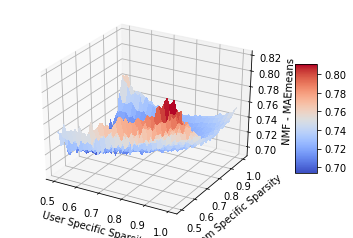

In [240]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

time_zero = time.time();

# Make data.
algoName = 'NMF'
evaluationParameter = 'MAEmeans'

A = np.array([])
B = np.array([])
#Z = np.array([[]])
Zline = np.array([])

firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)
A, B = np.meshgrid(A, B)

# Saving variables for future use
# Saving variables for future use
var_A_filename = 'NMF-MAE-A_meshgrid.csv'
var_B_filename = 'NMF-MAE-B_meshgrid.csv'
var_Z_filename = 'NMF-MAE-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')


#surf = ax.plot_surface(A, B, Z, rstride=1, cstride=1, cmap=cm.viridis)
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel(algoName+' - ' + evaluationParameter)

#plt.show()

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'-'+evaluationParameter+'.png');
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;

<h3>NMF - RMSE</h3>

[*] Saving variable to ./Results/Variables/100k/NMF-RMSE-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/NMF-RMSE-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/NMF-RMSE-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.364863872528


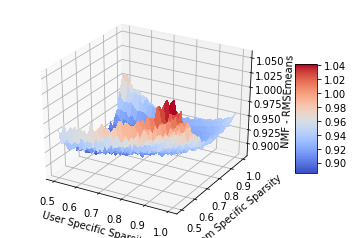

In [241]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

time_zero = time.time();

# Make data.
algoName = 'NMF'
evaluationParameter = 'RMSEmeans'

A = np.array([])
B = np.array([])
#Z = np.array([[]])
Zline = np.array([])

firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)
A, B = np.meshgrid(A, B)

# Saving variables for future use
var_A_filename = 'NMF-RMSE-A_meshgrid.csv'
var_B_filename = 'NMF-RMSE-B_meshgrid.csv'
var_Z_filename = 'NMF-RMSE-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')


#surf = ax.plot_surface(A, B, Z, rstride=1, cstride=1, cmap=cm.viridis)
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel(algoName+' - ' + evaluationParameter)

#plt.show()

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'-'+evaluationParameter+'.png');
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;